In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test_data_f32.ftr
/kaggle/input/train_data.ftr
/kaggle/input/train_data_f32.ftr
/kaggle/input/test_data.ftr


In [2]:
Train_df = pd.read_feather('/kaggle/input/train_data.ftr')
Train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


In [3]:
Train_df.shape

(5531451, 191)

In [4]:
Train_df = Train_df.groupby('customer_ID').tail(1)
Train_df.shape

(458913, 191)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
Train_df['target'].value_counts()

target
0    340085
1    118828
Name: count, dtype: int64

In [7]:
NullVal = pd.DataFrame({'Columns':Train_df.columns,
                           'Nulls':Train_df.isna().sum().values / len(Train_df)}).sort_values(by = ['Nulls'], ascending = False)

In [8]:
Drop_Columns = NullVal[NullVal['Nulls'] > 0.7]['Columns']

In [9]:
Drop_Columns

108     D_87
111     D_88
146    D_108
148    D_110
149    D_111
150     B_39
74      D_73
172     B_42
182    D_138
181    D_137
178    D_134
179    D_135
180    D_136
87       R_9
104     B_29
78      D_76
143     R_26
139    D_106
175    D_132
20      D_49
60      D_66
10      D_42
186    D_142
94      D_82
31      D_53
Name: Columns, dtype: object

In [10]:
Train_df = Train_df.drop(columns = Drop_Columns)
Train_df.shape

(458913, 166)

**Correlations and PCA**

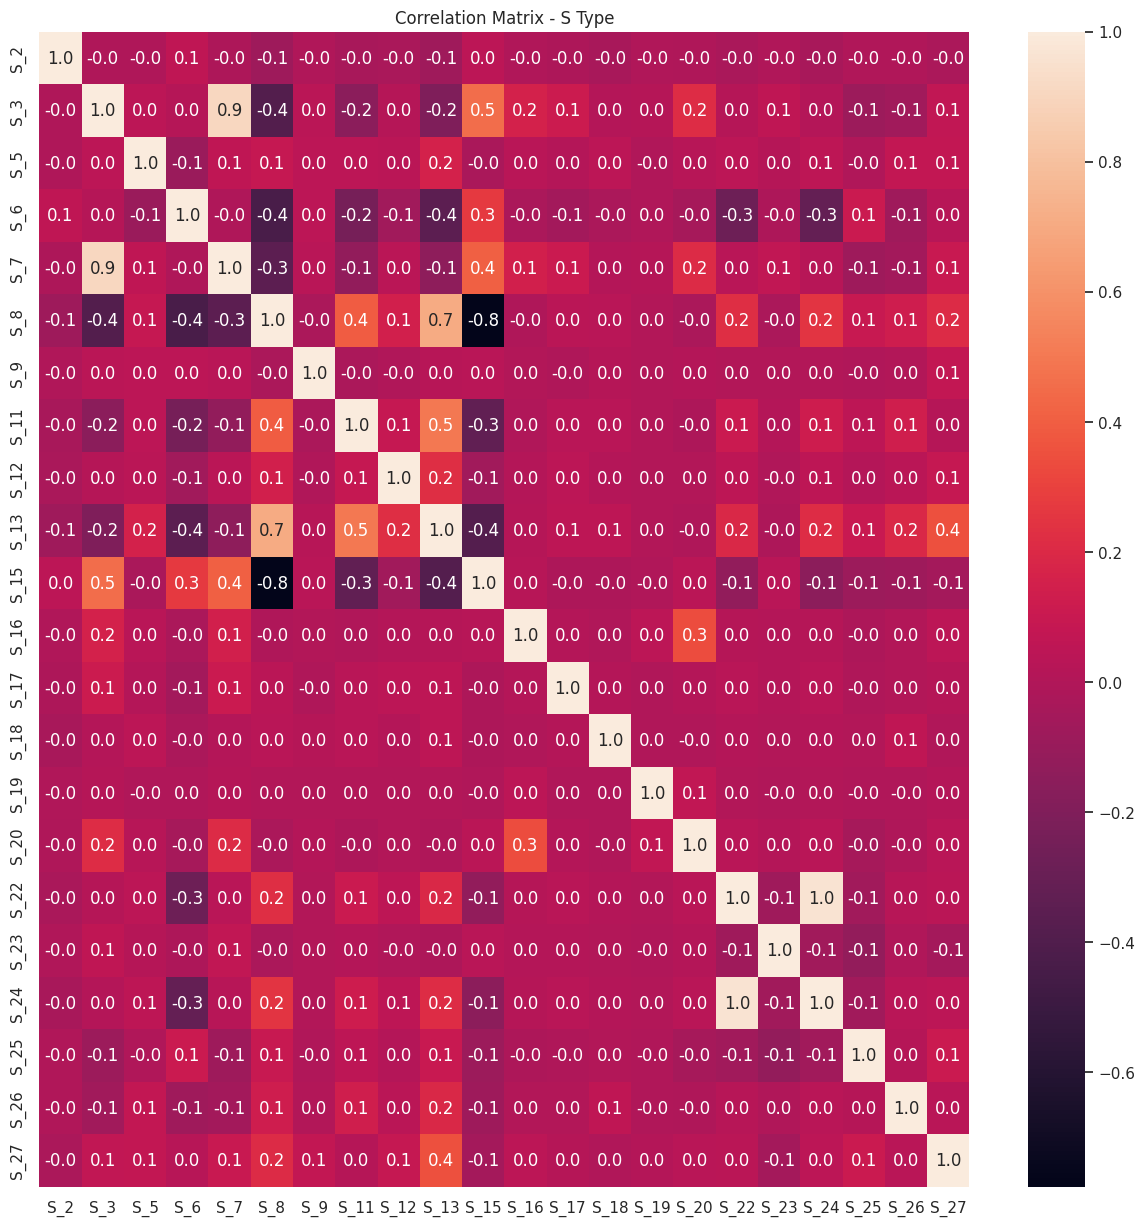

In [11]:
sns.set_theme()
plt.figure(figsize=(15, 15))
sns.heatmap(Train_df[[i for i in Train_df.columns if 'S' in i]].corr(), annot = True, fmt='.1f')
plt.title('Correlation Matrix - S Type')
plt.show()

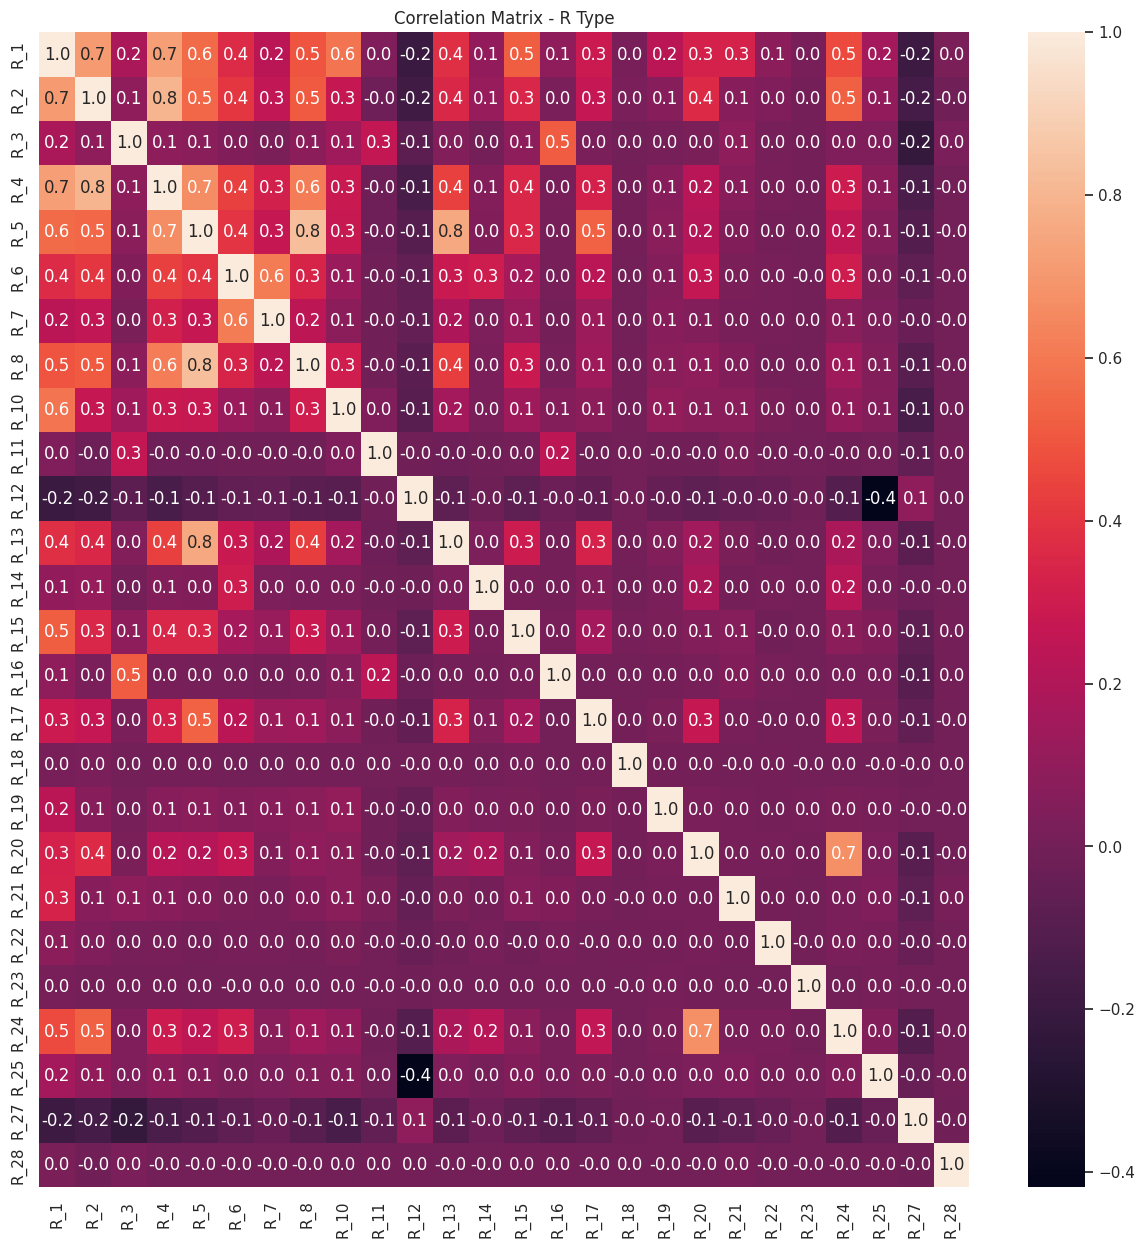

In [12]:
sns.set_theme()
plt.figure(figsize=(15, 15))
sns.heatmap(Train_df[[i for i in Train_df.columns if 'R' in i]].corr(), annot = True, fmt='.1f')
plt.title('Correlation Matrix - R Type')
plt.show()

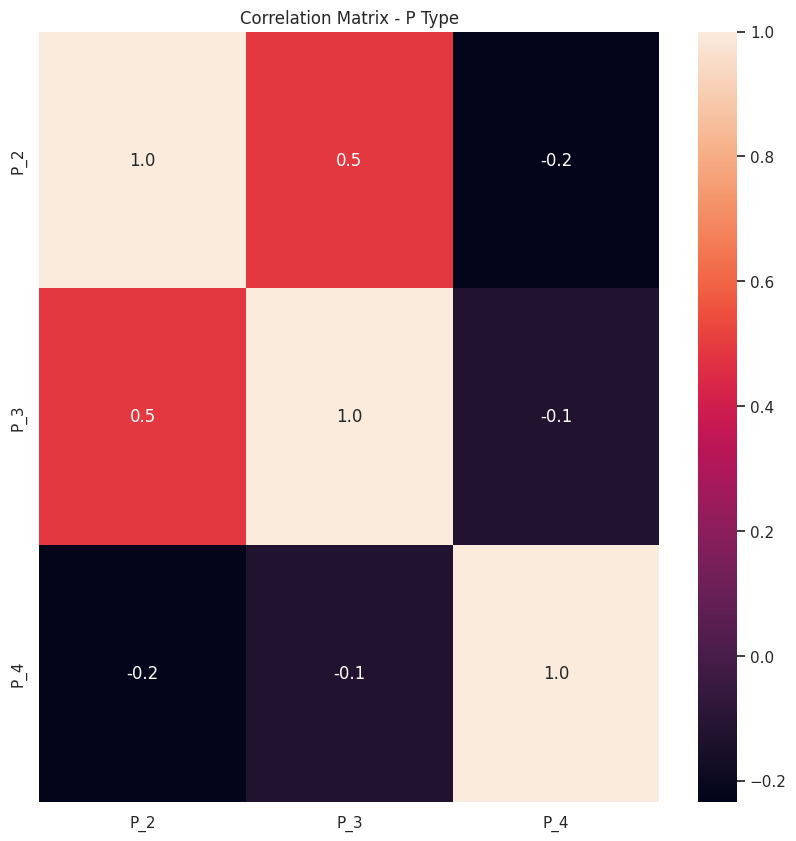

In [13]:
sns.set_theme()
plt.figure(figsize=(10, 10))
sns.heatmap(Train_df[[i for i in Train_df.columns if 'P' in i]].corr(), annot = True, fmt='.1f')
plt.title('Correlation Matrix - P Type')
plt.show()

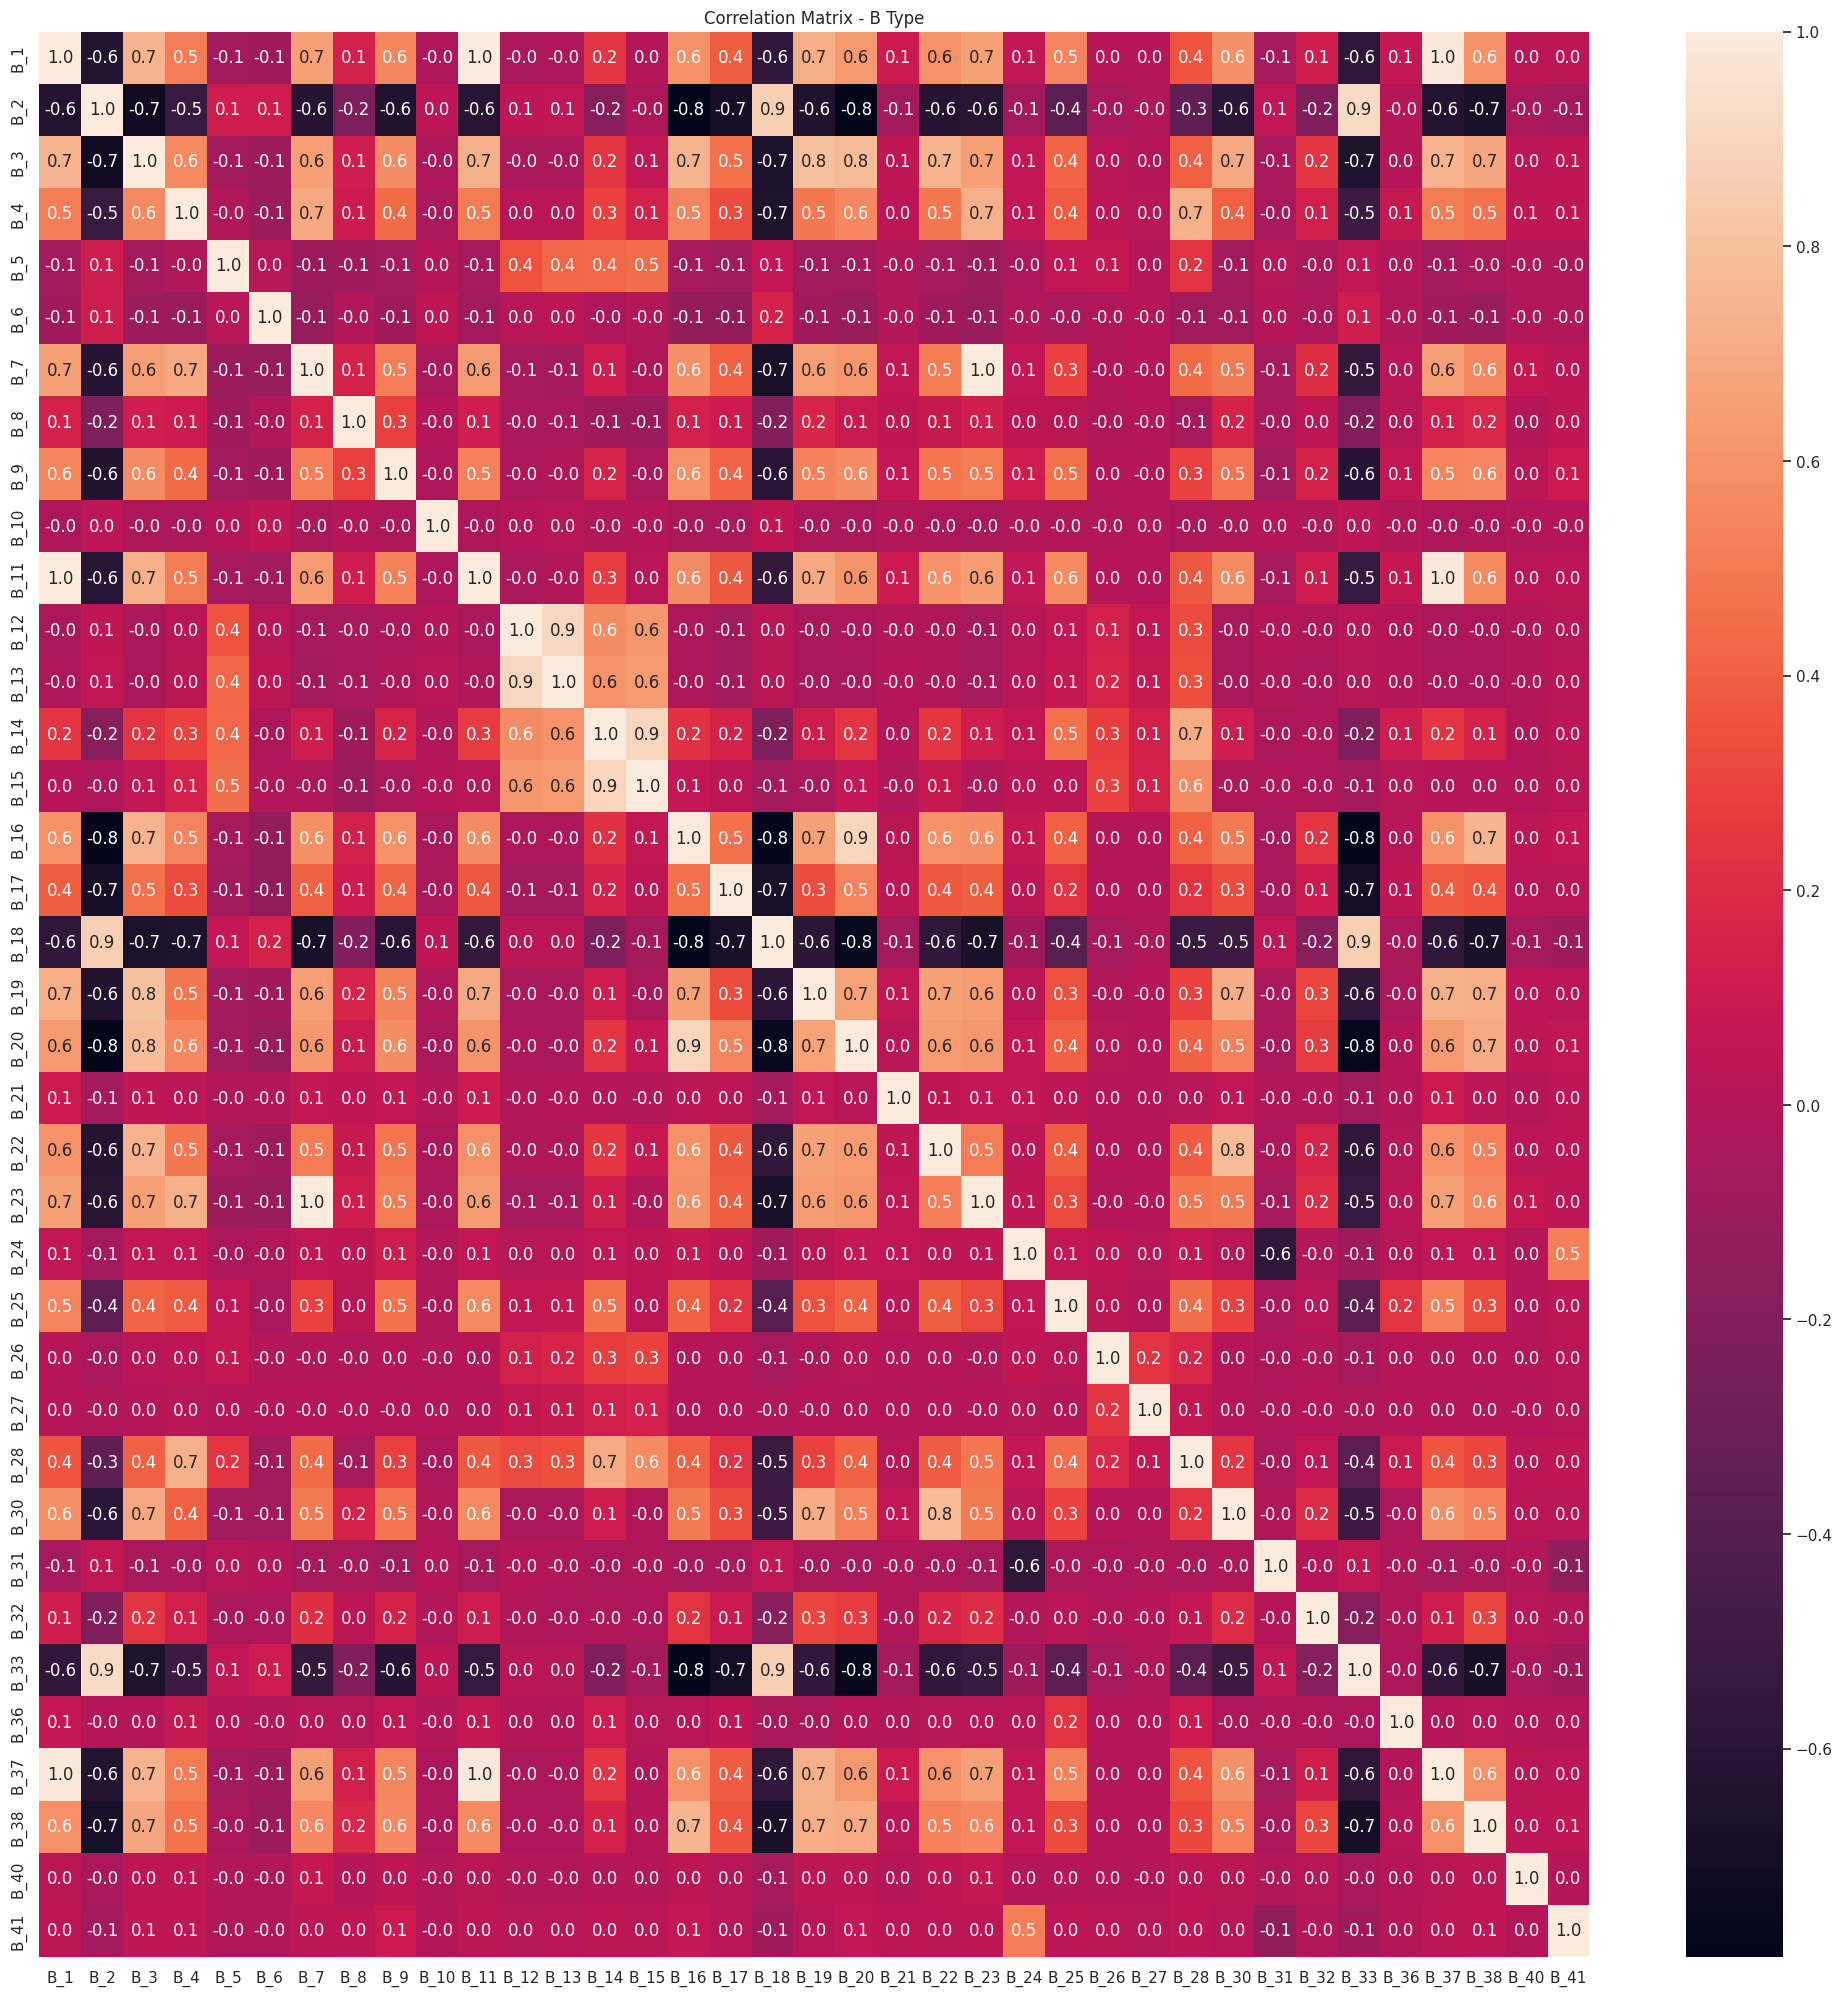

In [14]:
sns.set_theme()
plt.figure(figsize=(25, 25))
sns.heatmap(Train_df[[i for i in Train_df.columns if 'B' in i]].corr(), annot = True, fmt='.1f')
plt.title('Correlation Matrix - B Type')
plt.show()

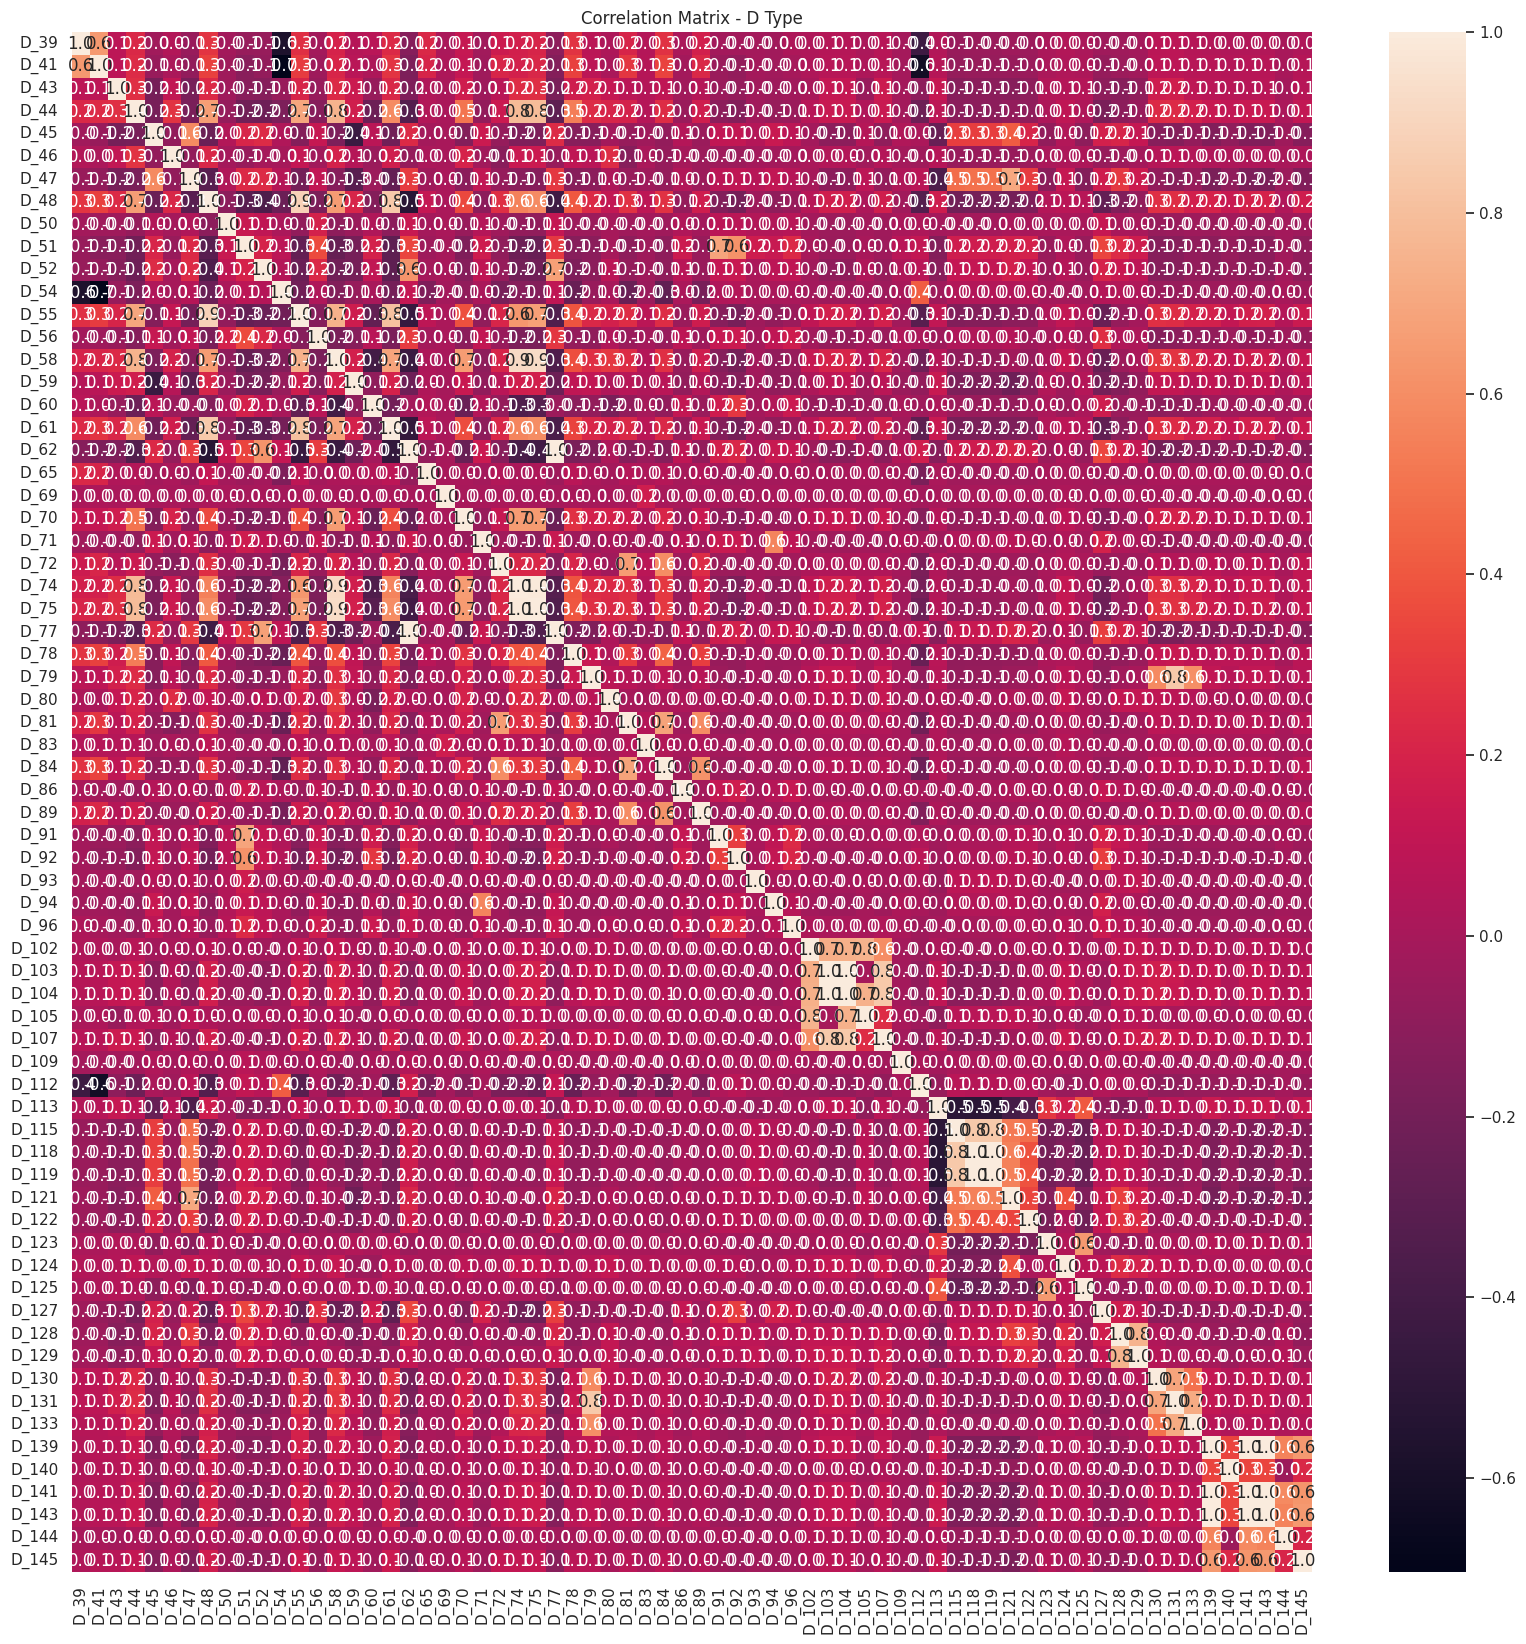

In [15]:
numerical_cols = Train_df.select_dtypes(exclude=['category']).columns

d_type_numerical_cols = [col for col in numerical_cols if 'D_' in col]

plt.figure(figsize=(20, 20))
sns.heatmap(Train_df[d_type_numerical_cols].corr(), annot=True, fmt='.1f')
plt.title('Correlation Matrix - D Type')
plt.show()

In [16]:
df = Train_df[['customer_ID','target']].reset_index(drop = True)

categorical = Train_df.select_dtypes(include='category').reset_index(drop = True)

In [17]:
categorical.dtypes.to_list()

[CategoricalDtype(categories=['CL', 'CO', 'CR', 'XL', 'XM', 'XZ'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['', '-1', 'O', 'R', 'U'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[0.0, 1.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[0.0, 1.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[0.0, 1.0], ordered=False, categories_dtype=float64),
 CategoricalDtype(categories=[-1.0, 0.0, 1.0], ordered=False, categories_dtype=float64)]

In [18]:
for i in categorical.columns:
    categorical[i].fillna(categorical[i].mode()[0], inplace = True)
    
categorical = pd.get_dummies(categorical, drop_first= True)

/tmp/ipykernel_67/1995452346.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  categorical[i].fillna(categorical[i].mode()[0], inplace = True)


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE 

In [20]:
numeric = Train_df.select_dtypes(include=['float16']).reset_index(drop = True)

for i in numeric.columns:
    numeric[i] = numeric[i].astype('float64')
    numeric[i] = numeric[i].fillna(numeric[i].mean())

numeric = pd.DataFrame(StandardScaler().fit_transform(numeric), columns = numeric.columns)
    
PCA_df = pd.concat([categorical, numeric], axis = 1)

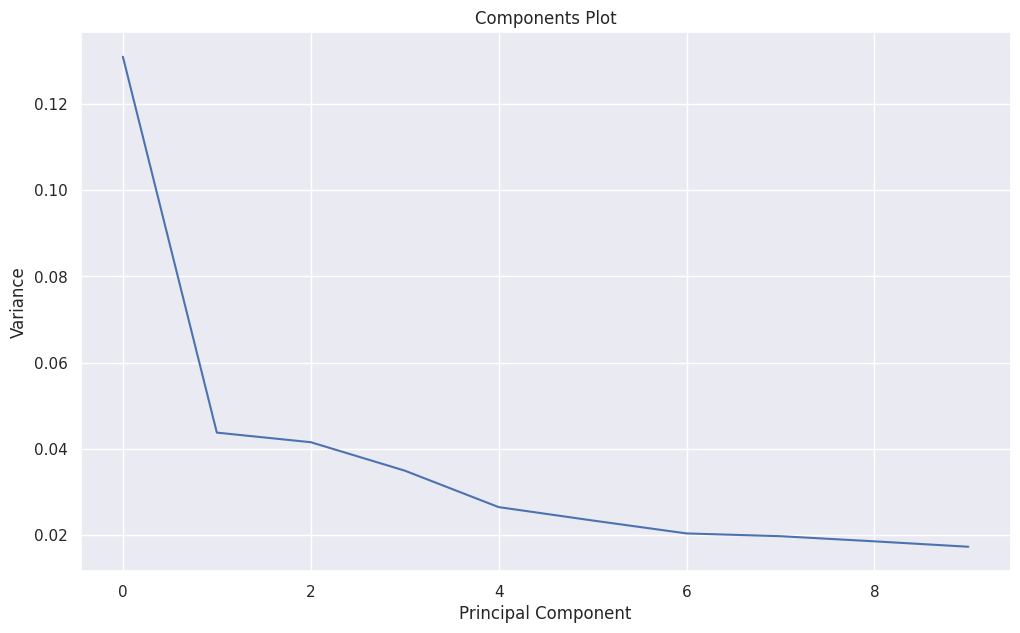

In [21]:
PCA_Model = PCA(n_components=10, random_state=0)
PCA_Model.fit(PCA_df)

plt.figure(figsize=(12, 7))
plt.plot(PCA_Model.explained_variance_ratio_)
plt.title('Components Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.show()

In [22]:
PCA_Model = PCA(n_components=6, random_state=0)
Temp = pd.DataFrame(PCA_Model.fit_transform(PCA_df))
df = pd.concat([df.iloc[:, :2], Temp], axis = 1)
df

,customer_ID,target,0,1,2,3,4,5
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,-4.850656,2.968600,1.735009,1.167599,-2.917427,-0.204454
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,-4.492042,0.055945,1.044690,-0.803476,1.412078,-0.341250
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,-4.085839,-1.653960,0.403771,-1.960947,1.325169,0.357446
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,-3.648545,-1.135330,0.217276,1.283302,0.808332,0.712615
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,-1.775848,-0.314665,-0.204324,-2.290428,-3.506362,1.697953
...,...,...,...,...,...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0,-3.984325,0.670569,0.840577,3.334058,-0.182782,0.501896
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0,2.307458,2.426636,-1.587259,-3.580942,-3.306888,1.374581
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0,-3.955579,0.109161,0.551566,1.390682,-0.592141,-0.518689
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1,0.798685,-2.639750,-1.971880,1.820177,-2.436101,-1.306482


**After PCA**

**SMOTE resampling**

In [23]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(df.iloc[:,2:], df['target'])

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, recall_score
from itertools import product
import random
import numpy as np
from sklearn.metrics import log_loss, confusion_matrix

In [26]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
def Randomized_kCrossValidation(X, y, model_class, param_grid, k_folds=5, random_sample_k=-1, eval_metric=recall_score, **fit_kwargs):
    """
    Perform randomized k-fold cross-validation for different models and hyperparameters.

    Parameters:
    - X, y: Input features and target variable
    - model_class: Class of the model (e.g., SVC, LogisticRegression, etc.)
    - param_grid: Dictionary of hyperparameters to search
    - k_folds: Number of folds in k-fold CV
    - random_sample_k: Number of random hyperparameter combinations to evaluate
    - eval_metric: Metric to evaluate (default: recall_score)
    - fit_kwargs: Additional keyword arguments for the model's fit method

    Returns:
    - best_params: Best hyperparameters based on the evaluation metric
    - best_metric: Best evaluation metric score
    """
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    if random_sample_k != -1:
        param_combinations = random.sample(param_combinations, random_sample_k)

    best_metric = -np.inf
    best_params = None

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for params in param_combinations:
        metrics = []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = model_class(**params)
            model.fit(X_train, y_train, **fit_kwargs)
            preds = model.predict(X_val)
            metrics.append(eval_metric(y_val, preds))

        avg_metric = np.mean(metrics)

        if avg_metric > best_metric:
            best_metric = avg_metric
            best_params = params

    print(f'Best Parameters: {best_params}, Best {eval_metric.__name__}: {best_metric}')
    return best_params, best_metric

In [28]:
svm_params = {
    'C': [1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

best_svm_params, _ = Randomized_kCrossValidation(
    train_X, train_y,
    model_class=lambda **params: BaggingClassifier(base_estimator=SVC(**params), n_estimators=64, max_samples=128, random_state=0, n_jobs=-1),
    param_grid=svm_params,
    k_folds=5,
    random_sample_k=15,
    eval_metric=recall_score
)

svm_model = BaggingClassifier(base_estimator=SVC(**best_svm_params), n_estimators=64, max_samples=128, random_state=0, n_jobs=-1)
svm_model.fit(train_X, train_y)
svm_preds = svm_model.predict(test_X)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/en

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, Best recall_score: 0.9337499859508942


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [29]:
logistic_params = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

best_logistic_params, _ = Randomized_kCrossValidation(
    train_X, train_y,
    model_class=LogisticRegression,
    param_grid=logistic_params,
    k_folds=5,
    random_sample_k=10,
    eval_metric=recall_score
)

logistic_model = LogisticRegression(**best_logistic_params)
logistic_model.fit(train_X, train_y)
logistic_preds = logistic_model.predict(test_X)

Best Parameters: {'solver': 'liblinear', 'C': 0.01}, Best recall_score: 0.8817348217239142


In [30]:
xgb_params = {
    'max_depth': [9, 10, 11, 12],
    'min_child_weight': [5, 6, 7, 8],
    'eta': [0.1, 0.01, 0.001],
    'objective': ['binary:logistic'],
    'tree_method': ['gpu_hist'],
    'eval_metric': ['logloss']
}

best_xgb_params, _ = Randomized_kCrossValidation(
    train_X, train_y,
    model_class=lambda **params: xgb.XGBClassifier(**params, verbosity=0, n_jobs=-1),
    param_grid=xgb_params,
    k_folds=5,
    random_sample_k=15,
    eval_metric=recall_score
)

xgb_model = xgb.XGBClassifier(**best_xgb_params, verbosity=0, n_jobs=-1)
xgb_model.fit(train_X, train_y)
xgb_preds = xgb_model.predict(test_X)

Best Parameters: {'max_depth': 12, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'logloss'}, Best recall_score: 0.9182901046577452


In [31]:
print('Accuracy:', accuracy_score(test_y, xgb_preds))
print('Log Loss:', log_loss(test_y, xgb_preds))
print('ROC Accuracy:', roc_auc_score(test_y, xgb_preds))
print('Classification report:\n', 
       classification_report(test_y, xgb_preds))

Accuracy: 0.8887827062842133
Log Loss: 4.008677585567455
ROC Accuracy: 0.8887828569174796
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89    102026
           1       0.87      0.92      0.89    102025

    accuracy                           0.89    204051
   macro avg       0.89      0.89      0.89    204051
weighted avg       0.89      0.89      0.89    204051



In [32]:
print('Accuracy:', accuracy_score(test_y, logistic_preds))
print('Log Loss:', log_loss(test_y, logistic_preds))
print('ROC Accuracy:', roc_auc_score(test_y, logistic_preds))
print('Classification report:\n', 
       classification_report(test_y, logistic_preds))

Accuracy: 0.875379194417082
Log Loss: 4.491789121503253
ROC Accuracy: 0.8753792239792737
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87    102026
           1       0.87      0.88      0.88    102025

    accuracy                           0.88    204051
   macro avg       0.88      0.88      0.88    204051
weighted avg       0.88      0.88      0.88    204051



In [33]:
print('Accuracy:', accuracy_score(test_y, svm_preds))
print('Log Loss:', log_loss(test_y, svm_preds))
print('ROC Accuracy:', roc_auc_score(test_y, svm_preds))
print('Classification report:\n', 
       classification_report(test_y, svm_preds))

Accuracy: 0.8574228991771665
Log Loss: 5.1389996032834215
ROC Accuracy: 0.8574232890451028
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85    102026
           1       0.81      0.94      0.87    102025

    accuracy                           0.86    204051
   macro avg       0.87      0.86      0.86    204051
weighted avg       0.87      0.86      0.86    204051



In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
 early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

neuralnet =  keras.Sequential([
    layers.Dense(32, input_shape = [6]),
    layers.Dropout(.2,),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(1, activation='sigmoid'),
])

neuralnet.compile(
    optimizer='adam',
    loss='BinaryCrossentropy',
    metrics = ['MeanSquaredLogarithmicError']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
history = neuralnet.fit(train_X, train_y,
                           validation_data=(test_X, test_y,),
                           callbacks=[early_stopping],
                           batch_size=500,
                           epochs=1000,
                           verbose=1)

Epoch 1/1000


I0000 00:00:1733869584.798813     156 service.cc:145] XLA service 0x7ede40002600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733869584.798863     156 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 98/953 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanSquaredLogarithmicError: 0.0745 - loss: 0.4378

I0000 00:00:1733869586.895998     156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - MeanSquaredLogarithmicError: 0.0509 - loss: 0.3279 - val_MeanSquaredLogarithmicError: 0.0428 - val_loss: 0.2849
Epoch 2/1000
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - MeanSquaredLogarithmicError: 0.0433 - loss: 0.2889 - val_MeanSquaredLogarithmicError: 0.0429 - val_loss: 0.2842
Epoch 3/1000
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - MeanSquaredLogarithmicError: 0.0430 - loss: 0.2873 - val_MeanSquaredLogarithmicError: 0.0426 - val_loss: 0.2838
Epoch 4/1000
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - MeanSquaredLogarithmicError: 0.0429 - loss: 0.2862 - val_MeanSquaredLogarithmicError: 0.0429 - val_loss: 0.2837
Epoch 5/1000
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - MeanSquaredLogarithmicError: 0.0430 - loss: 0.2870 - val_MeanSquaredLogarithmicError: 0.0428 - val_loss: 0.2833
Epoch 6/1000
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - MeanSquaredLogarithmicError: 0.0431 - loss: 0.2875 - val_MeanSquaredLogarithmicError: 0.0424 - val_loss: 0.2832
Epoch

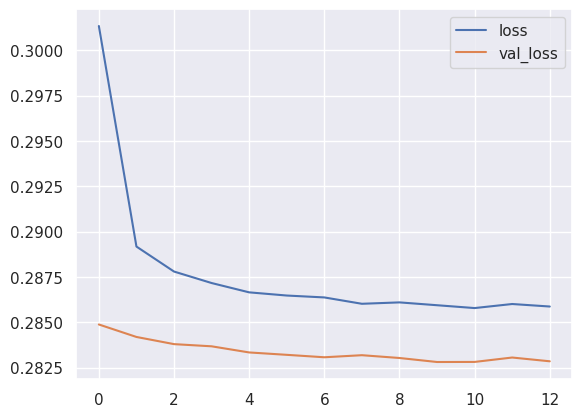

In [37]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot();

Plateaus steadily and both losses decrease. No divergent change between them so no overfitting.

In [38]:
pred = neuralnet.predict(test_X).round(0).astype(int)

6377/6377 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [39]:
print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Classification report:\n', 
       classification_report(test_y, pred))

Accuracy: 0.8801035035358807
Log Loss: 4.321507761122225
ROC Accuracy: 0.8801036601492238
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88    102026
           1       0.86      0.91      0.88    102025

    accuracy                           0.88    204051
   macro avg       0.88      0.88      0.88    204051
weighted avg       0.88      0.88      0.88    204051

